In [12]:
import numpy as np
import cv2
import pandas as pd
import pickle
import os
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from yellowbrick.classifier import ROCAUC
import matplotlib.pyplot as plt

In [13]:
# ============================
# STEP 1: READ TRAINING IMAGES AND EXTRACT FEATURES
# ============================
image_dataset = pd.DataFrame()  # Dataframe untuk menyimpan fitur gambar

img_path = "C:/Users/zidan/Downloads/Compressed/sandstone_data_for_ML/train"
for image in os.listdir(img_path):
    print(f"Processing: {image}")

    df = pd.DataFrame()  # Temporary DataFrame
    input_img = cv2.imread(os.path.join(img_path, image))

    # Convert to grayscale jika RGB
    if input_img.ndim == 3:
        img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    else:
        img = input_img

    # Menambahkan pixel value
    df['Pixel_Value'] = img.flatten()
    df['Image_Name'] = image

    # ================================
    # Gabor Filter (Extract Texture Features)
    # ================================
    num = 1
    kernels = []
    for theta in range(2):  # 2 orientasi
        theta = theta / 4. * np.pi
        for sigma in (1, 3):  # 2 sigma values
            for lamda in np.arange(0, np.pi, np.pi / 4):  # 4 lamda values
                for gamma in (0.05, 0.5):  # 2 gamma values
                    ksize = 9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
                    kernels.append(kernel)
                    fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                    df[f'Gabor{num}'] = fimg.flatten()
                    num += 1

    # ================================
    # Edge Detection Features
    # ================================
    df['Canny Edge'] = cv2.Canny(img, 100, 200).flatten()
    df['Roberts'] = roberts(img).flatten()
    df['Sobel'] = sobel(img).flatten()
    df['Scharr'] = scharr(img).flatten()
    df['Prewitt'] = prewitt(img).flatten()

    # ================================
    # Gaussian & Median Filtering
    # ================================
    df['Gaussian s3'] = nd.gaussian_filter(img, sigma=3).flatten()
    df['Gaussian s7'] = nd.gaussian_filter(img, sigma=7).flatten()
    df['Median s3'] = nd.median_filter(img, size=3).flatten()

    # Update dataset dengan data dari gambar ini
    image_dataset = pd.concat([image_dataset, df], ignore_index=True)


Processing: train_images_256_256_256.tif


In [15]:
# ============================
# STEP 2: READ MASKS (LABEL DATA)
# ============================
mask_dataset = pd.DataFrame()

mask_path = "C:/Users/zidan/Downloads/Compressed/sandstone_data_for_ML/masks"
for mask in os.listdir(mask_path):
    print(f"Processing Mask: {mask}")

    df2 = pd.DataFrame()
    input_mask = cv2.imread(os.path.join(mask_path, mask), cv2.IMREAD_GRAYSCALE)
    
    df2['Label_Value'] = input_mask.flatten()
    df2['Mask_Name'] = mask

    mask_dataset = pd.concat([mask_dataset, df2], ignore_index=True)

Processing Mask: train_masks_256_256_256.tif


In [16]:
# ============================
# STEP 3: PREPARE DATA FOR RANDOM FOREST
# ============================
dataset = pd.concat([image_dataset, mask_dataset], axis=1)

# Hapus pixel dengan label 0 (jika ada)
dataset = dataset[dataset.Label_Value != 0]

# X = Fitur, Y = Label
X = dataset.drop(columns=["Image_Name", "Mask_Name", "Label_Value"])
Y = dataset["Label_Value"].values

# Encode Y
Y = LabelEncoder().fit_transform(Y)

# Split train dan test data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)


In [17]:
# ============================
# STEP 4: TRAINING RANDOM FOREST MODEL
# ============================
model = RandomForestClassifier(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

Accuracy = 0.95


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


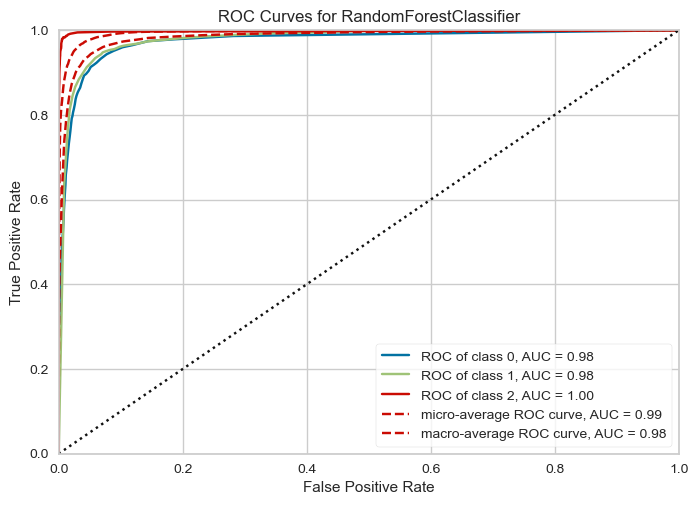

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [18]:
# ============================
# STEP 5: CHECK ACCURACY
# ============================
prediction_test = model.predict(X_test)
print(f"Accuracy = {metrics.accuracy_score(y_test, prediction_test):.2f}")

# ROC Curve
roc_auc = ROCAUC(model, classes=np.unique(Y))
roc_auc.fit(X_train, y_train)
roc_auc.score(X_test, y_test)
roc_auc.show()

In [19]:
# ============================
# STEP 6: SAVE THE MODEL
# ============================
model_filename = "sandstone_model_multi_image.pkl"
pickle.dump(model, open(model_filename, 'wb'))
print(f"Model saved as {model_filename}")

Model saved as sandstone_model_multi_image.pkl
